In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=5000,shuffle=True) #Create validation dataset by splitting train dataset

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(45000, 32, 32, 3)
(45000, 1)
(10000, 32, 32, 3)
(10000, 1)
(5000, 32, 32, 3)
(5000, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical #Convert labels to categorical data
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(45000, 10)
(10000, 10)
(5000, 10)


In [ ]:
x_train=x_train/255. #Normalize all datasets by dividing it by 255.
x_test=x_test/255.
x_val=x_val/255.

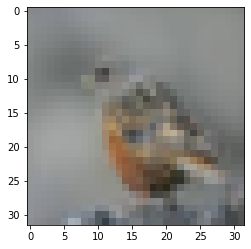

In [ ]:
plt.imshow(x_train[0])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(x_train)

In [ ]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (3, 3), strides=1,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        #self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        #self.res_4_1 = ResnetBlock(512, down_sample=True)
        #self.res_4_2 = ResnetBlock(512)
        self.max_pool = MaxPool2D(pool_size=(2,2))
        self.drop1=Dropout(0.1)
        self.drop2=Dropout(0.25)
        #self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        #out = self.pool_2(out)
        out = self.res_1_1(out)
        out = self.res_1_2(out)
        out=self.drop1(out)
        out = self.res_2_1(out)
        out = self.res_2_2(out)
        out=self.drop1(out)
        out = self.res_3_1(out)
        out = self.res_3_2(out)
        #out=self.drop2(out)
        #out = self.res_4_1(out)
        #out = self.res_4_2(out)
        #out=self.drop(out)
        #for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2]:
         #   out = res_block(out)
         #   out=self.drop(out)
        out = self.max_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD,Adam
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
opt=Adam(learning_rate=0.001)
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 74368     
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple              

In [ ]:
from keras.callbacks import EarlyStopping

#es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")callbacks=[es]
#I did not use cross validation, so the validate performance is not accurate. #steps_per_epoch=STEPS
STEPS = len(x_train) / 256
#
history = model.fit(aug.flow(x_train,y_train,batch_size = 128), batch_size = 128, epochs=150, validation_data=(x_val, y_val))

Epoch 1/150
352/352 [==============================] - 47s 112ms/step - loss: 2.1084 - accuracy: 0.3916 - val_loss: 1.4976 - val_accuracy: 0.4774
Epoch 2/150
352/352 [==============================] - 33s 94ms/step - loss: 1.3939 - accuracy: 0.5390 - val_loss: 1.2328 - val_accuracy: 0.5602
Epoch 3/150
352/352 [==============================] - 35s 99ms/step - loss: 1.1348 - accuracy: 0.6297 - val_loss: 2.0510 - val_accuracy: 0.6324
Epoch 4/150
352/352 [==============================] - 34s 96ms/step - loss: 0.9415 - accuracy: 0.6932 - val_loss: 1.1221 - val_accuracy: 0.6190
Epoch 5/150
352/352 [==============================] - 33s 95ms/step - loss: 0.8294 - accuracy: 0.7323 - val_loss: 0.7957 - val_accuracy: 0.7250
Epoch 6/150
352/352 [==============================] - 34s 95ms/step - loss: 0.7301 - accuracy: 0.7636 - val_loss: 0.7795 - val_accuracy: 0.7308
Epoch 7/150
352/352 [==============================] - 34s 95ms/step - loss: 0.6461 - accuracy: 0.7882 - val_loss: 0.8703 - val_a

In [ ]:
ModelLoss, ModelAccuracy = model.evaluate(x_test, y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 3s 10ms/step - loss: 0.5453 - accuracy: 0.9088
Model Loss is 0.5452798008918762
Model Accuracy is 0.9088000059127808


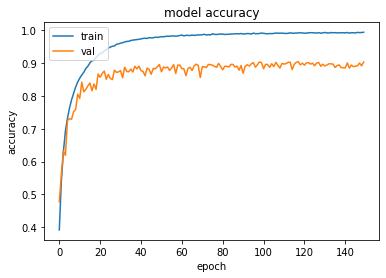

In [ ]:
#ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

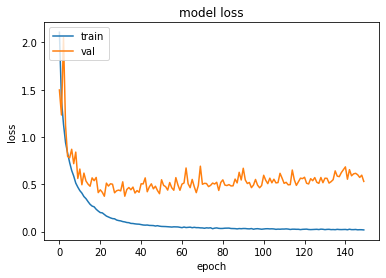

In [ ]:
#LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import keras
model.save('/content/drive/MyDrive/DL_midterm/midterm',save_format="tf")
path='/content/drive/MyDrive/DL_midterm/midterm'
model = keras.models.load_model(path)